In [5]:
%matplotlib ipympl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import numpy as np
import jax
import jax.numpy as jnp
import metrics
import importlib
importlib.reload(metrics)
from metrics import compute_metrics, normalized_multiinformation
import scripts.train_toy
importlib.reload(scripts.train_toy)
from scripts.train_toy import generate_square_data
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import einops
sns.set_theme()

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[383, 375, 355, 319, 288]


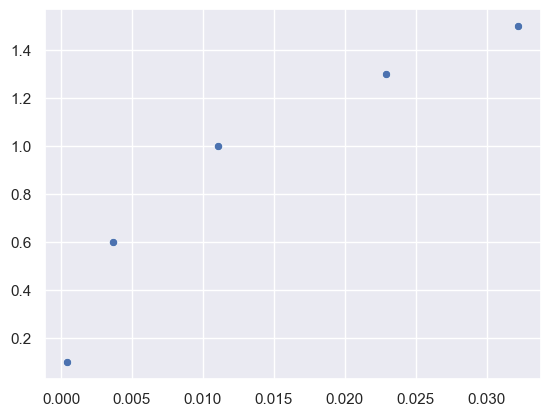

In [87]:
def load_data(slice, correlated_sampling_factor, covariance, *, key):
    dataset = np.load('/iris/u/kylehsu/code/modular/isaac3d_reduced.npz')
    x = dataset['x']
    x = x.astype(np.float32) / 255
    x = x * 2 - 1
    x = einops.rearrange(x, 'n h w c -> n c h w')
    s = dataset['s']
    
    assert not (slice > 0 and correlated_sampling_factor > 0)
    if slice > 0:
        keep = np.sum(s, axis=1) >= slice
        s = s[keep]
        x = x[keep]
    elif correlated_sampling_factor > 0:
        d = s.shape[1]
        mean = np.zeros((d,))
        cov = covariance * np.ones((d, d)) + (1 - covariance) * np.eye(d)
        s_correlated = jax.random.multivariate_normal(key, mean, cov, (int(correlated_sampling_factor * s.shape[0]),))
        quantiles = np.quantile(s_correlated, np.array([0.005, 0.995]), axis=0)
        quantile_range = np.mean(quantiles[1] - quantiles[0])
        s_correlated = s_correlated / quantile_range + 0.5
        s_correlated_quantized = []
        for i in range(d):
            n_values = len(np.unique(s[:, i]))
            s_correlated_quantized.append(np.round(s_correlated[:, i] * (n_values - 1)) / (n_values - 1))
        s_correlated_quantized = np.stack(s_correlated_quantized, axis=1)
        s_correlated_quantized = s_correlated_quantized[
            np.all((s_correlated_quantized >= 0) & (s_correlated_quantized <= 1), axis=1)
        ]
        # for each row of s_correlated_quantized, find the index of the same row in s
        # then use that index to get the corresponding row in x
        # then concatenate all the rows of x
        x_correlated = []
        for i in range(s_correlated_quantized.shape[0]):
            i_s = np.where(np.all(np.isclose(s, s_correlated_quantized[i], atol=1e-5), axis=1))[0][0]
            x_correlated.append(x[i_s])
        x_correlated = np.stack(x_correlated, axis=0)
        x = np.concatenate([x, x_correlated], axis=0)
        s = np.concatenate([s, s_correlated_quantized], axis=0)

    return {
        'x': x,
        's': s
    }

lens = []
slices = [0.1, 0.6, 1.0, 1.3, 1.5]
snmis = []
for slice in slices:
    dataset = load_data(slice, 0, 0, key=jax.random.PRNGKey(8254))
    s = dataset['s']
    lens.append(len(dataset['x']))
    snmis.append(normalized_multiinformation(s))
print(lens)
fig, ax = plt.subplots()
sns.scatterplot(x=snmis, y=slices, ax=ax)
fig

[384, 386, 387, 389, 390]


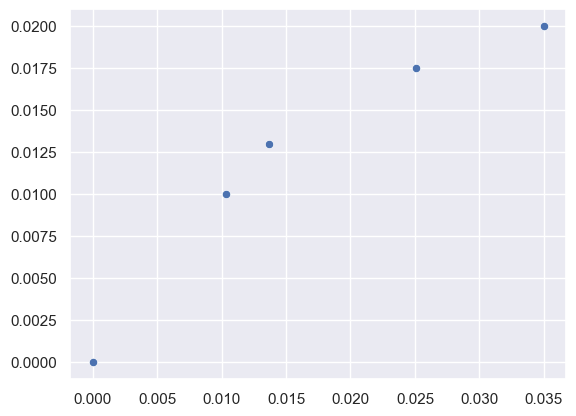

In [90]:
snmis = []
lens = []
factors = [0, 0.01, 0.013, 0.0175, 0.02]
for factor in factors:
    dataset = load_data(0, factor, 0.9, key=jax.random.PRNGKey(0))
    s = dataset['s']
    lens.append(len(dataset['x']))
    snmis.append(normalized_multiinformation(s))
print(lens)
fig, ax = plt.subplots()
sns.scatterplot(x=snmis, y=factors, ax=ax)
fig

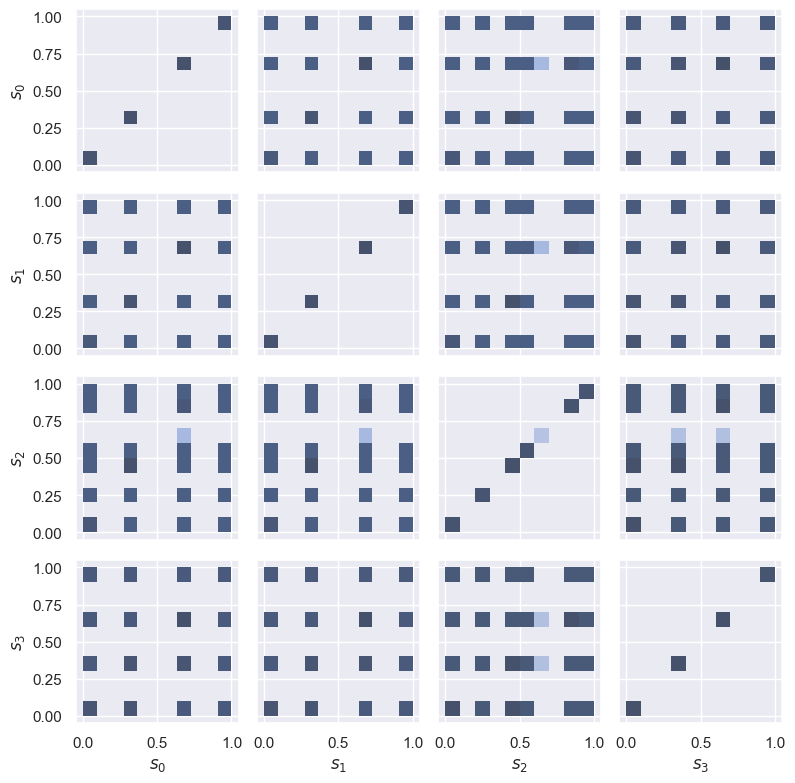

In [86]:
ds = 4
fig, axes = plt.subplots(ds, ds, figsize=(2 * ds, 2 * ds), sharex=True, sharey=True)
for i in range(ds):
    for j in range(ds):
        ax = axes[i][j]
        sns.histplot(
            ax=ax,
            x=s[:, j],
            y=s[:, i],
            rasterized=True,
        )
        ax.set_xlabel(rf'$s_{{{j}}}$')
        ax.set_ylabel(rf'$s_{{{i}}}$')
        ax.set_aspect('equal')
fig.tight_layout()
fig

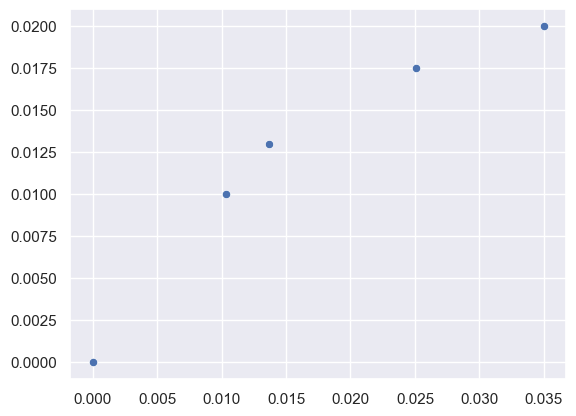

In [85]:
fig, ax = plt.subplots()
sns.scatterplot(x=snmis, y=factors, ax=ax)
fig

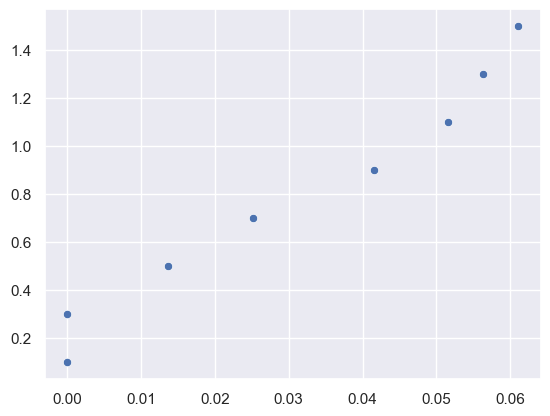

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x=snmis, y=slices, ax=ax)
fig

In [3]:
sns.scatterplot(x=snmis, y=slices)

<Axes: >

In [40]:
d = 3
n_values_per_source = 21
xs = []
lens = []
slices = np.linspace(0.1, 1.5, 15)
for slice in slices:
    dataset = generate_square_data(d, n_values_per_source, slice=slice, correlated_sampling_factor=0, covariance=0, key=jax.random.PRNGKey(0))
    s = dataset['s']
    lens.append(len(s))
    xs.append(normalized_multiinformation(s))

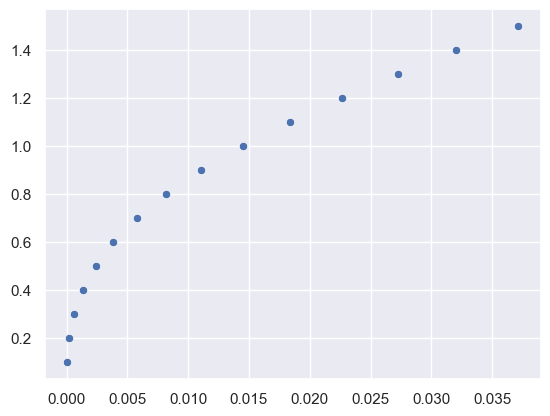

In [41]:
fig, ax = plt.subplots()
sns.scatterplot(x=xs, y=slices, ax=ax)
fig

In [7]:
xs = []
lens = []
factors = np.linspace(0, 0.04, 15)
# for covariance in covariances:
for factor in factors:
    dataset = generate_square_data(d, n_values_per_source, slice=0, correlated_sampling_factor=factor, covariance=0.9, key=jax.random.PRNGKey(0))
    s = dataset['s']
    lens.append(len(s))
    xs.append(normalized_multiinformation(s))

NameError: name 'd' is not defined

In [8]:
factors

array([0.        , 0.00285714, 0.00571429, 0.00857143, 0.01142857,
       0.01428571, 0.01714286, 0.02      , 0.02285714, 0.02571429,
       0.02857143, 0.03142857, 0.03428571, 0.03714286, 0.04      ])

In [43]:
lens

[9261,
 9286,
 9311,
 9338,
 9364,
 9389,
 9417,
 9441,
 9467,
 9493,
 9522,
 9547,
 9573,
 9597,
 9625]

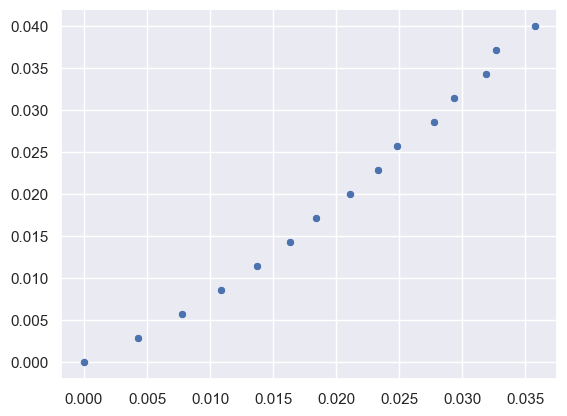

In [44]:
fig, ax = plt.subplots()
sns.scatterplot(x=xs, y=factors, ax=ax)
fig

In [45]:
21**3

9261

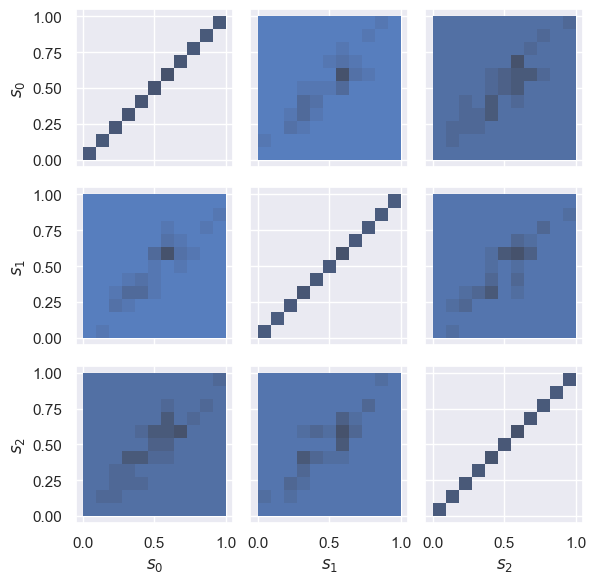

In [30]:
ds = 3
fig, axes = plt.subplots(ds, ds, figsize=(2 * ds, 2 * ds), sharex=True, sharey=True)
for i in range(ds):
    for j in range(ds):
        ax = axes[i][j]
        sns.histplot(
            ax=ax,
            x=s[:, j],
            y=s[:, i],
            rasterized=True,
            bins=11
        )
        ax.set_xlabel(rf'$s_{{{j}}}$')
        ax.set_ylabel(rf'$s_{{{i}}}$')
        ax.set_aspect('equal')
fig.tight_layout()
fig